### Load libraries

In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import utils

plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("2-col")]
)

### Figure 5a & 5b

In [2]:
from pathlib import Path
from sgfmill.sgf import Sgf_game


root = Path("/nas/ucb/norabelrose/latest@1600-dragonslayer-fixed/cleaned")
games = [
    Sgf_game.from_string(p.open().read())
    for p in root.rglob('*.sgf')
]
selfplay_games = [
    Sgf_game.from_string(line)
    for p in Path("/nas/ucb/k8/go-attack/match/ttseng-cp505-v2048-vs-self-20221118-195315").rglob('*.sgfs')
    for line in p.open()
]

In [3]:
import numpy as np
import re


def get_stats_selfplay(games: list, color: str = "w") -> tuple[np.ndarray, np.ndarray]:
    """Return (`win_rates`, `gt_wins`) as a tuple."""
    game_lengths = np.array([len(g.get_main_sequence()) - 1 for g in games])
    num_moves = min(game_lengths)

    winrates = np.full((len(games), num_moves), np.nan)
    wins = np.full(len(games), np.nan)

    # Regex that matches exactly 4 decimal numbers separated by spaces
    probs_regex = re.compile(r'^(\d\.\d+) (\d\.\d+) (\d\.\d+) (-?\d+\.\d+)')
    for i, game in enumerate(games):
        root = game.get_root()
        if not root.has_property("RE"):
            continue

        sequence = game.get_main_sequence()
        sequence.pop(0)  # Remove root node
        sequence = sequence[-num_moves:]

        winner, _ = root.get("RE").split("+")
        wins[i] = winner.lower() == color

        # The first node is the root, which has no move, so skip it
        for j, node in enumerate(sequence):
            cur_color, _ = node.get_move()
            if cur_color.lower() != color:
                continue

            comment = node.get('C').strip()
            assert comment

            maybe_match = probs_regex.match(comment)
            assert maybe_match

            # These are all from white's perspective
            win, loss, _, score = map(float, maybe_match.groups())
            if color == "b":
                win, loss = loss, win
                score = -score

            # Winrate probabilities in KataGo are logged up to the 2nd decimal place,
            # so we clip them to [0.01, 0.99] to avoid numerical issues in the BCE
            # calculation
            winrates[i, j] = np.clip(win, 0.01, 0.99)
    
    return winrates, wins


In [4]:
black_winrates, black_wins = get_stats_selfplay(selfplay_games, color="b")
white_winrates, white_wins = get_stats_selfplay(selfplay_games, color="w")
raw_white_loss = -(white_wins[:, None] * np.log(white_winrates) + (1 - white_wins[:, None]) * np.log(1 - white_winrates))
raw_black_loss = -(black_wins[:, None] * np.log(black_winrates) + (1 - black_wins[:, None]) * np.log(1 - black_winrates))

In [5]:
import numpy as np
import re


def get_stats(games: list, time_to_end: bool = False) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return (`adv_win_rates`, `victim_win_rates`, `adv_wins`) as a tuple.

    `np.nan` is used as a filler for turns after the game ends, or for moves
    where it's not the {adversary,victim}'s turn.
    
    Args:
        games: A list of sgfmill.Sgf_game objects.
        time_to_end: Whether to align games s.t. they all end at the same time.
    
    Returns:
        adv_win_rates: A floating point array of the adversary's win rates.
        victim_win_rates: A floating point array of the victim's win rates.
        adv_wins: A 1D boolean array which is True at index i iff the adversary won game i.
    """
    game_lengths = np.array([len(g.get_main_sequence()) - 1 for g in games])
    num_moves = min(game_lengths) if time_to_end else max(game_lengths)

    adv_win_rates = np.full((len(games), num_moves), np.nan)
    victim_win_rates = np.full((len(games), num_moves), np.nan)
    adv_wins = np.full(len(games), np.nan)

    # Regex that matches exactly 4 decimal numbers separated by spaces
    probs_regex = re.compile(r'^(\d\.\d+) (\d\.\d+) (\d\.\d+) (-?\d+\.\d+)')
    for i, game in enumerate(games):
        root = game.get_root()
        if not root.has_property("RE"):
            continue

        black, white = root.get('PB').strip('"'), root.get('PW').strip('"')
        assert sorted([black, white]) == ['adversary', 'victim']

        adv_color = "b" if black == 'adversary' else "w"
        sequence = game.get_main_sequence()
        sequence.pop(0)  # Remove root node
        if time_to_end:
            sequence = sequence[-num_moves:]

        winner, _ = root.get("RE").split("+")
        adv_won = winner.lower() == adv_color
        adv_wins[i] = adv_won

        for j, node in enumerate(sequence):
            comment = node.get('C').strip()
            assert comment

            maybe_match = probs_regex.match(comment)
            assert maybe_match

            # These are all from white's perspective
            win, loss, draw, score = map(float, maybe_match.groups())
            if adv_color == "b":
                win, loss = loss, win
                score = -score

            cur_color, _ = node.get_move()
            if cur_color == adv_color:
                # Winrate probabilities in KataGo are logged up to the 2nd decimal place,
                # so we clip them to [0.01, 0.99] to avoid numerical issues in the BCE
                # calculation
                adv_win_rates[i, j] = np.clip(win, 0.01, 0.99)
            else:
                victim_win_rates[i, j] = np.clip(win, 0.01, 0.99)
    
    return adv_win_rates, victim_win_rates, adv_wins


[  0  40  80 120 160 200]
[  0  40  80 120 160 200]
[  0  40  80 120 160 200 240]


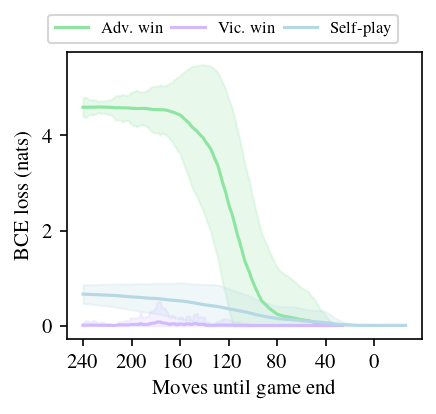

In [6]:
import matplotlib.pyplot as plt

def plot(x, label, color):
    mean_victim_loss = np.nanmean(x, axis=0)
    victim_loss_std = np.nanstd(x, axis=0)

    kernel = np.ones(10) / 10
    smoothed_victim_bce_loss = np.convolve(mean_victim_loss, kernel, mode='valid')
    smoothed_victim_bce_loss_std = np.convolve(victim_loss_std, kernel, mode='valid')

    plt.plot(smoothed_victim_bce_loss, label=label, c=color)
    plt.xlabel('Moves until game end')
    plt.ylabel('BCE loss (nats)')

    plt.fill_between(
        np.arange(len(smoothed_victim_bce_loss)),
        np.clip(smoothed_victim_bce_loss - smoothed_victim_bce_loss_std, a_min=0, a_max=None),
        np.clip(smoothed_victim_bce_loss + smoothed_victim_bce_loss_std, a_min=0, a_max=None),
        alpha=0.2,
        color=color,
    )
    ticks = np.arange(0, len(smoothed_victim_bce_loss), 40)
    plt.xticks(ticks, ticks[::-1])
    print(ticks)

fig = plt.figure(figsize=(2.6448 + 0.15, 2.6448), dpi=150)

_, victim_win_rates, gt_adv_wins = get_stats(games, time_to_end=True)
raw_victim_loss = -(gt_adv_wins[:, None] * np.log(victim_win_rates) + (1 - gt_adv_wins[:, None]) * np.log(1 - victim_win_rates))
plot(raw_victim_loss[gt_adv_wins.astype(bool)], label="Adv. win", color=(0.5529411764705883, 0.8980392156862745, 0.6313725490196078))
plot(raw_victim_loss[~gt_adv_wins.astype(bool)], "Vic. win", color=(0.8156862745098039, 0.7333333333333333, 1.0))
plot(raw_white_loss, label='Self-play', color=(0.71372549, 0.84313725, 0.89411765))
plt.legend(loc="lower center", bbox_to_anchor=(0.44, 1.0), columnspacing=0.5, ncol=3, fancybox=True, fontsize=8)

plt.savefig('winrate-avg.pgf', backend='pgf')

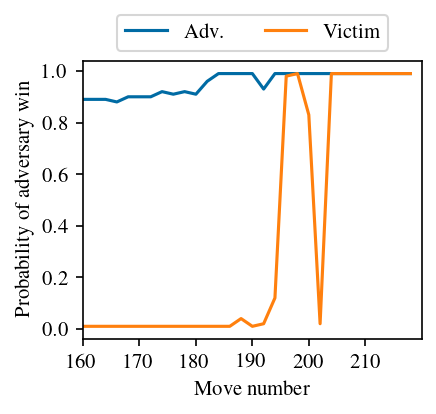

In [7]:
plt.rcParams.update(
    {
        "figure.subplot.left": 0.2,
        "figure.subplot.right": 0.95,
        "figure.subplot.bottom": 0.2,
    }
)

fig5b_game = Sgf_game.from_string(open(root / "9C6532F01A5E87E3D227BC12FC9443B7.sgf").read())
adv_win_rates, victim_win_rates, adv_wins = get_stats([fig5b_game])
adv_trunc = adv_win_rates[0, :220:2]
victim_trunc = victim_win_rates[0, 1:220:2]

plt.figure(figsize=(2.6448 + 0.15, 2.6448), dpi=150)
plt.plot(adv_trunc, label="Adv.")
plt.plot(victim_trunc, label="Victim")
plt.xticks(
    np.arange(80, 110, 5),
    np.arange(80, 110, 5) * 2
)
plt.xlim(80, 110)

plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=2, fancybox=True)
plt.xlabel("Move number")
plt.ylabel("Probability of adversary win")

plt.savefig('fig-5b.pgf', backend='pgf')